# **Classification problem**
Rich people classification based on NYC taxi rides dataset.

Author: Róber Belanec

This notebook is an appendix to the written homework 2 to score some bonus points from task 2. (c.

At first we will download the NYC yellow taxi rides dataset. After that we will import modules and load csv files into a dataframe. We are using datasets from may, june and july 2021.

In [1]:
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2021-07.csv
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2021-06.csv
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2021-05.csv

--2021-11-28 22:19:33--  https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2021-07.csv
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.130.177
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.130.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261410655 (249M) [text/csv]
Saving to: ‘yellow_tripdata_2021-07.csv.1’

yellow_tripdata_202 100%[===================>] 249.30M  74.0MB/s    in 3.5s    

2021-11-28 22:19:36 (71.4 MB/s) - ‘yellow_tripdata_2021-07.csv.1’ saved [261410655/261410655]

--2021-11-28 22:19:36--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2021-06.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.97.229
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.97.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262656180 (250M) [text/csv]
Saving to: ‘yellow_tripdata_2021-06.csv.1’

yellow_tripdata_202 100%[===================>] 250.4

In [24]:
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split

In [3]:
path = '/content'
all_files = glob.glob(path + '/*.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_yellow = pd.concat(li, axis=0, ignore_index=True)

print('Old size: ', len(df_yellow))
df_yellow = df_yellow.dropna()
print('New size: ', len(df_yellow))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Old size:  8162888
New size:  7781398


As you can see, we have been dropping NA values from each csv. Therefore we have now 7781398 taxi rides left.

Now we can check the dataset basic structure and its datatypes:

In [4]:
df_yellow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2021-05-01 00:37:18,2021-05-01 00:41:07,2.0,0.70,1.0,N,141,263,1.0,5.0,3.0,0.5,2.20,0.0,0.3,11.00,2.5
1,1.0,2021-05-01 00:43:01,2021-05-01 00:49:19,1.0,1.40,1.0,N,263,75,2.0,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5
2,1.0,2021-05-01 00:05:54,2021-05-01 00:31:46,1.0,5.70,1.0,N,142,129,2.0,21.5,3.0,0.5,0.00,0.0,0.3,25.30,2.5
3,2.0,2021-05-01 00:08:21,2021-05-01 00:19:20,1.0,3.04,1.0,N,231,97,1.0,11.5,0.5,0.5,3.06,0.0,0.3,18.36,2.5
4,2.0,2021-05-01 00:32:44,2021-05-01 00:48:44,1.0,4.04,1.0,N,148,17,1.0,15.5,0.5,0.5,5.79,0.0,0.3,25.09,2.5


In [5]:
df_yellow.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

To see value anges means and more, we can use pandas describe function:

In [6]:
df_yellow.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06,7.781398e+06
mean,1.695512e+00,1.440628e+00,3.038025e+00,1.054315e+00,1.653180e+02,1.632367e+02,1.250852e+00,1.268655e+01,1.044107e+00,4.924701e-01,2.303809e+00,3.335950e-01,2.970423e-01,1.879308e+01,2.286863e+00
std,4.601902e-01,1.049367e+00,6.432167e+00,8.834931e-01,6.566293e+01,7.048385e+01,4.725840e-01,1.197728e+01,1.243526e+00,7.759291e-02,2.734579e+00,1.736321e+00,4.151922e-02,1.462989e+01,7.316379e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-6.435000e+02,-5.500000e+00,-5.000000e-01,-1.111000e+02,-3.375000e+01,-3.000000e-01,-6.478000e+02,-2.500000e+00
25%,1.000000e+00,1.000000e+00,1.080000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.147000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.476000e+01,2.500000e+00
75%,2.000000e+00,2.000000e+00,3.130000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.400000e+01,2.500000e+00,5.000000e-01,3.000000e+00,0.000000e+00,3.000000e-01,2.016000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,1.315552e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,5.954000e+03,9.006000e+01,4.550000e+00,4.492100e+02,9.565500e+02,3.000000e-01,5.954000e+03,2.750000e+00


As we have stated in our written homework, to predict, if the customer is rather rich, we will be using drop off location, passenger count and tip amount. We will pick only those and rename the columns.

We can also find passenger count values that are 0. We will replace them with 1 as we assume that it's not possible to have 0 passengers.

In [7]:
df_important = df_yellow[['DOLocationID', 'passenger_count', 'tip_amount']].rename(columns={'DOLocationID':'location', 'passenger_count':'passengers', 'tip_amount':'tip'})
df_important['passengers'].replace({0:1}, inplace=True)

Now we will calculate the tip per passenger and get a mean from it.

In [8]:
tips = (df_important['tip'] / df_important['passengers'])
tips_mean = tips.mean()
print('Mean of tips per passenger:', tips_mean)

Mean of tips per passenger: 1.9522823101731621


As we can see, the mean is around 1.95 per passenger. Now we will set the marigin 1 that will mean that every ride that had tip more than 2.95

In [9]:
margin = 1
print('Number of rich people: ', len(df_important.loc[df_important['tip'] / df_important['passengers'] > tips_mean + margin]))
print('Number of not rich people: ', len(df_important.loc[df_important['tip'] / df_important['passengers'] <= tips_mean + margin]))

Number of rich people:  1631059
Number of not rich people:  6150339


In [10]:
df_important.loc[df_important['tip'] / df_important['passengers'] > tips_mean + margin, 'rich'] = 1
df_important.loc[df_important['tip'] / df_important['passengers'] <= tips_mean + margin, 'rich'] = 0
df_important.head()

,location,passengers,tip,rich
0,263,2.0,2.20,0.0
1,75,1.0,0.00,0.0
2,129,1.0,0.00,0.0
3,97,1.0,3.06,1.0
4,17,1.0,5.79,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


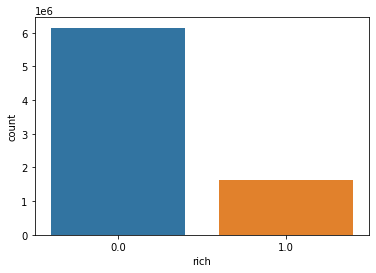

In [11]:
sns.countplot(df_important['rich'])

In [14]:
data = df_important.to_numpy()
X = data[:, :-1]
y = data[:, -1]

print('Data shape: ', data.shape)
print('X shape: ', X.shape)
print('y shape: ', y.shape)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

Data shape:  (7781398, 4)
X shape:  (7781398, 3)
y shape:  (7781398,)
X_train shape:  (5213536, 3)
y_train shape:  (5213536,)
X_test shape:  (2567862, 3)
y_test shape:  (2567862,)


Our first attempt was to use SVMs for this problem. But regarding to SO [article](https://datascience.stackexchange.com/questions/989/svm-using-scikit-learn-runs-endlessly-and-never-completes-execution), it's not recomended to use SVM when we have over 200K observations (or we can approximate the kernel matrix using K-means). We will use neural networks then.

In [23]:
mlp = Sequential()
mlp.add(Dense(100, activation='tanh', input_dim=X_train.shape[1]))
mlp.add(Dense(100, activation='tanh'))
mlp.add(Dense(2, activation='softmax'))

mlp.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.04),  metrics=['accuracy'])

history = mlp.fit(X_train, tf.keras.utils.to_categorical(y_train), epochs=30, validation_split=0.1, verbose=True)

Epoch 1/30
146631/146631 [==============================] - 332s 2ms/step - loss: 0.5161 - accuracy: 0.8023 - val_loss: 0.5828 - val_accuracy: 0.8877
Epoch 2/30
146631/146631 [==============================] - 337s 2ms/step - loss: 0.4198 - accuracy: 0.8371 - val_loss: 0.3548 - val_accuracy: 0.8766
Epoch 3/30
146631/146631 [==============================] - 333s 2ms/step - loss: 0.3759 - accuracy: 0.8568 - val_loss: 0.3172 - val_accuracy: 0.8876
Epoch 4/30
146631/146631 [==============================] - 332s 2ms/step - loss: 0.3354 - accuracy: 0.8696 - val_loss: 0.3695 - val_accuracy: 0.8229
Epoch 5/30
146631/146631 [==============================] - 332s 2ms/step - loss: 0.3340 - accuracy: 0.8733 - val_loss: 0.3784 - val_accuracy: 0.8699
Epoch 6/30
146631/146631 [==============================] - 337s 2ms/step - loss: 0.3221 - accuracy: 0.8811 - val_loss: 0.3300 - val_accuracy: 0.8744
Epoch 7/30
146631/146631 [==============================] - 340s 2ms/step - loss: 0.3149 - accuracy:

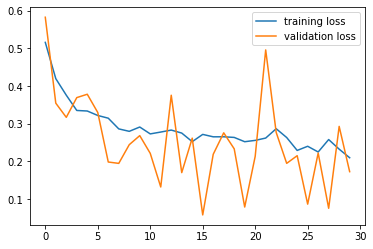

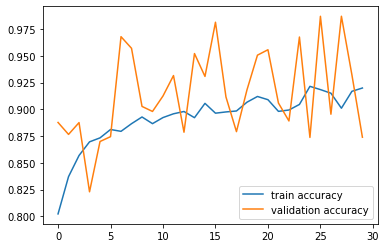

In [25]:
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

In [26]:
train_score = mlp.evaluate(X_train, tf.keras.utils.to_categorical(y_train))
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = mlp.evaluate(X_test, tf.keras.utils.to_categorical(y_test))
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

162923/162923 [==============================] - 308s 2ms/step - loss: 0.1737 - accuracy: 0.8737


train loss: 0.17368768155574799 | train acc: 0.8736529350280762

80246/80246 [==============================] - 113s 1ms/step - loss: 0.1744 - accuracy: 0.8736


test loss: 0.17438951134681702 | test acc: 0.8735967874526978
